In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset

import random
import joblib
from google.colab import files
import matplotlib.dates as mdates

In [ ]:
import tensorflow as tf

seed = 311
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# To enforce determinism on operations
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SDE_driven/savè.xlsx')

discharge = daily.iloc[:1280, 0].to_numpy()
plui = daily.iloc[:1280, 1].to_numpy()
etp = daily.iloc[:1280, 2].to_numpy()

discharge1 = daily.iloc[1280:, 0].to_numpy()
plui1 = daily.iloc[1280:, 1].to_numpy()
etp1 = daily.iloc[1280:, 2].to_numpy()

In [ ]:
#Calibration data
discharge = daily.iloc[:1280, 0].to_numpy()
plui = daily.iloc[:1280, 1].to_numpy()
etp = daily.iloc[:1280, 2].to_numpy()

#Validation data
discharge1 = daily.iloc[1280:, 0].to_numpy()
plui1 = daily.iloc[1280:, 1].to_numpy()
etp1 = daily.iloc[1280:, 2].to_numpy()

In [ ]:
discharge[0]

np.float64(0.0640000030398369)

In [ ]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


In [ ]:
# Create DataFrame for training (calibration)
data_train = pd.DataFrame({
    'prec': plui,
    'pet': etp,

    'target': discharge
})

# Create DataFrame for validation (test)
data_test = pd.DataFrame({
    'prec': plui1,
    'pet': etp1,

    'target': discharge1
})

# Concatenate the two DataFrames (calibration + validation)
data = pd.concat([data_train, data_test], ignore_index=True)


WKAN

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN')

In [ ]:
# import tensorflow as tf

# from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from utils import EarlyStopping,KAN,KANLinear,kan_prediction_plots
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
# import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(142)

Wavelet

In [ ]:
 !pip install PyWavelets

In [ ]:
import pywt

In [ ]:
# Wavelet transform function
def wavelet_transform(data, wavelet='coif1', level=6):
        coeffs = pywt.wavedec(data, wavelet, level=level)
        approx_coeffs = coeffs[0]
        transformed_data = pywt.waverec([approx_coeffs] + [None]*(len(coeffs)-1), wavelet)
        return transformed_data[:len(data)]


In [ ]:
# Exclude the last column ('target')
columns_to_transform = data.columns[:-1]  # All columns except the last one
data_transformed = data[columns_to_transform].apply(lambda x: wavelet_transform(x, wavelet='db2', level=4), axis=0)

# Reattach the 'target' column without transformation
data_transformed['target'] = data['target']

# Preserve column names
data_transformed = pd.DataFrame(data_transformed, columns=data.columns)

# Convert to pd.DataFrame
data = pd.DataFrame(data_transformed)

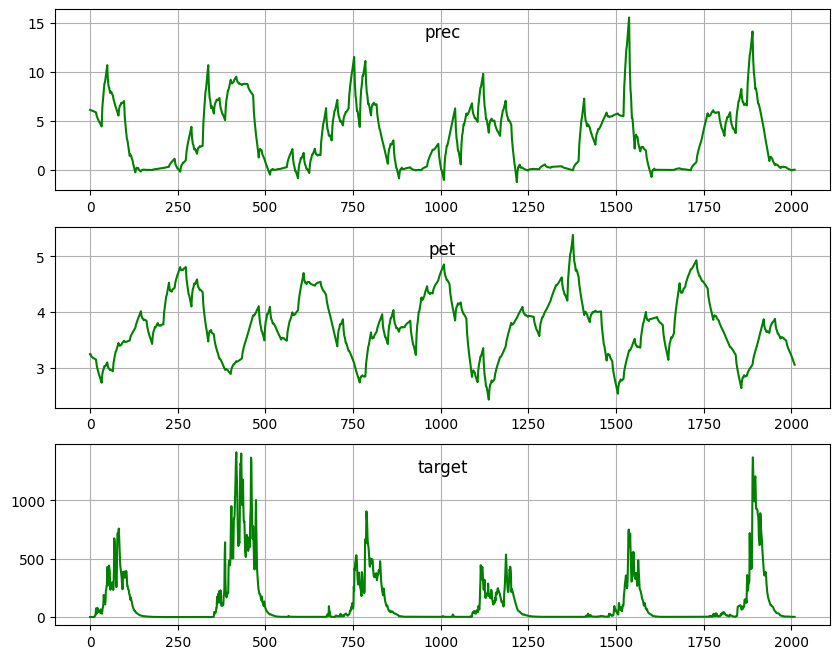

In [ ]:
plt.figure(figsize=(10,8))
list_vars = data.columns
for i, var in enumerate(list_vars):
  plt.subplot(data.shape[1], 1, i+1)
  plt.plot(data[var], color='green')
  plt.title(var,y=0.8)

In [ ]:
def Make_tidydata_for_kan(data,scaler,data_type="full"):
    if data_type=="full":
        data= data.sort_index()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        # print("data:",data.shape)
    # Splitting the dataset into training, validation, and test sets
    train_size = 1280
    val_size = 730
    #Train_val_test sets
    Xy_train = data[:train_size]
    Xy_val= data[train_size:]
    return [Xy_train,Xy_val]

def data_loading(Xy):
    X, y = Xy.values[:, :-1], Xy.values[:, -1]
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    dataset = TensorDataset(X, y)

    batch_size = len(dataset)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return loader


In [ ]:
# Function to make predictions on a full DataLoader
def predict_all(model, loader):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch, update_grid=False)
            predictions.append(y_pred)
            targets.append(y_batch)

    predictions = torch.cat(predictions, dim=0).numpy().flatten()
    targets = torch.cat(targets, dim=0).numpy().flatten()
    return predictions, targets

def train_test_loop_for_Q(data, epochs, scaler, scaler_y, layers_hidden=[9, 39, 1]):
    import copy

    data_copy = data.copy()

    list_data = Make_tidydata_for_kan(data_copy, scaler)
    train_loader, val_loader = [data_loading(d) for d in list_data]

    input_size = data_copy.shape[1] - 1
    local_layers_hidden = layers_hidden.copy()
    local_layers_hidden[0] = input_size

    Kan_network = KAN(layers_hidden=local_layers_hidden).to(torch.float32)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Kan_network.parameters(), lr=0.001)
    Kan_network.train()

    best_val_nse = -np.inf  # very low initialization
    best_model_state = None  # variable to store the best model

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        # Training
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = Kan_network(X_batch, update_grid=False)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)

        # Validation
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred_ = Kan_network(X_batch, update_grid=False)
                loss_ = criterion(y_pred_, y_batch)
                epoch_val_loss += loss_.item()

        avg_val_loss = epoch_val_loss / len(val_loader)

        # NSE
        y_train_pred, y_train_true = predict_all(Kan_network, train_loader)
        y_val_pred, y_val_true = predict_all(Kan_network, val_loader)

        y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_train_true = scaler_y.inverse_transform(y_train_true.reshape(-1, 1)).flatten()
        y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_true.reshape(-1, 1)).flatten()

        nse_train = nash_sutcliffe_efficiency(y_train_true, y_train_pred)
        nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

        # If best validation NSE is reached, save model weights
        if nse_val > best_val_nse:
            best_val_nse = nse_val
            best_model_state = copy.deepcopy(Kan_network.state_dict())

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/{epochs}] | Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f} | Train NSE: {nse_train:.4f} | Val NSE: {nse_val:.4f}")

    # Load the weights of the best model
    Kan_network.load_state_dict(best_model_state)

    # Final predictions with the best model
    y_train_pred, y_train_true = predict_all(Kan_network, train_loader)
    y_val_pred, y_val_true = predict_all(Kan_network, val_loader)

    y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_train_true = scaler_y.inverse_transform(y_train_true.reshape(-1, 1)).flatten()
    y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
    y_val_true = scaler_y.inverse_transform(y_val_true.reshape(-1, 1)).flatten()

    nse_train = nash_sutcliffe_efficiency(y_train_true, y_train_pred)
    nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

    print(f"\n Final NSE Train (best model) : {nse_train:.4f} | Final NSE Val (best model) : {nse_val:.4f}")

    return Kan_network, y_train_pred, y_val_pred


In [ ]:
# Prepare the scaler for the features
scaler = StandardScaler()

# Prepare the scaler for the target Q
scaler_y = StandardScaler()

# Data and number of epochs
data, epochs = data, 400
print(data.shape)

# Fit the scaler for the target (Q): last column
scaler_y.fit(data.iloc[:, -1].values.reshape(-1, 1))

# Model training (prediction of Q)
model, pred_train, pred_test = train_test_loop_for_Q(data, epochs, scaler, scaler_y, layers_hidden=[2, 64, 1])


(2010, 3)
Epoch [0/400] | Train MSE: 0.9737 | Val MSE: 0.7774 | Train NSE: 0.0980 | Val NSE: 0.1047
Epoch [50/400] | Train MSE: 0.6390 | Val MSE: 0.5397 | Train NSE: 0.4007 | Val NSE: 0.3784
Epoch [100/400] | Train MSE: 0.6050 | Val MSE: 0.5000 | Train NSE: 0.4322 | Val NSE: 0.4242
Epoch [150/400] | Train MSE: 0.5691 | Val MSE: 0.4700 | Train NSE: 0.4661 | Val NSE: 0.4586
Epoch [200/400] | Train MSE: 0.5279 | Val MSE: 0.4808 | Train NSE: 0.5048 | Val NSE: 0.4463
Epoch [250/400] | Train MSE: 0.4906 | Val MSE: 0.5307 | Train NSE: 0.5397 | Val NSE: 0.3888
Epoch [300/400] | Train MSE: 0.4598 | Val MSE: 0.5669 | Train NSE: 0.5686 | Val NSE: 0.3471
Epoch [350/400] | Train MSE: 0.4334 | Val MSE: 0.5708 | Train NSE: 0.5933 | Val NSE: 0.3426

 Final NSE Train (best model) : 0.4777 | Final NSE Val (best model) : 0.4615


In [ ]:
# Training Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge, pred_train)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge, pred_train)
print('RMSE =', rmse)

r2 = calculate_r2(discharge, pred_train)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.4776542722584045
RMSE = 170.36327852682305
R² = 0.4779754896564518


In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge1, pred_test)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, pred_test)
print('RMSE =', rmse)

r2 = calculate_r2(discharge1, pred_test)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.4614620936494013
RMSE = 156.23417295834375
R² = 0.4689615936820442


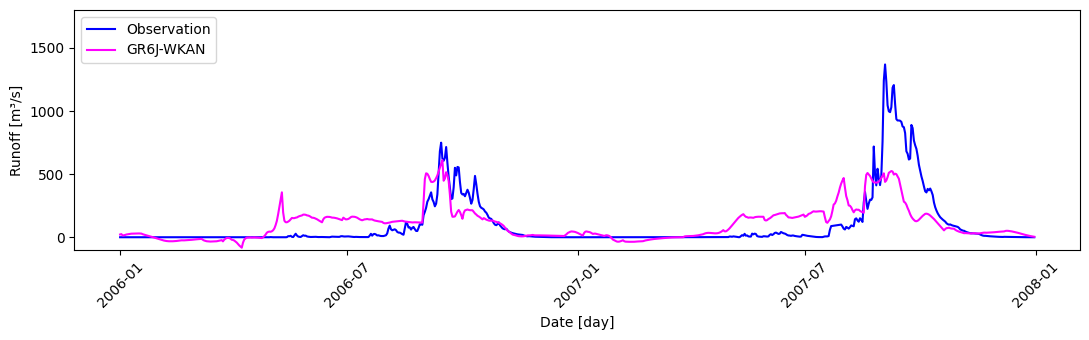

In [ ]:
# Generate dates
time1 = np.datetime64('2006-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))


# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, pred_test, 'magenta', label='GR6J-WKAN', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-100, 1800)
ax.set_yticks(np.arange(0, 1800, 500))

# Add legend
ax.legend(loc='upper left')

# Show grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("GR6J_WKAN.jpeg", format='jpeg', dpi=700)

#files.download("GR6J_WKAN.jpeg")

ax.grid(False)


# Show plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory into an Excel file
df_mean_trajectory = pd.DataFrame({'WKAN': pred_test})

# Save to an Excel file
df_mean_trajectory.to_excel('WKAN.xlsx', index=False)

# Download the file in Google Colab
files.download('WKAN.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>